### CAPSTONE PROJECT
- PERFORM BLUR DETECTION
-CNN Architecture:
>    - First set of CNN ->RELU -> Pool layers
>    - Second set of CNN ->RELU ->Pool layers
>    - Flatten then Dense =500
>    - Activation = Softmax
>    - Learning rate =1e-3
>    - Batch size = 32
-Evaluation metrics (ROC-AUC, accuracy,f- score)

In [48]:
# Import Libraries
import numpy as np
import cv2
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import cv2
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input, InputLayer, Flatten
from tensorflow.keras.models import Sequential, Model
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

The given data is composed of three folders containing blurry and not blurry images. To make it easier for me to process the data, I combined the non blurry images in 1 folder. Then, i create a directory folder for the train, test and validation data: 80% for training, 10% for testing, and also, 10% for validation.

In [2]:
import splitfolders 
input_folder = "C:/Users/Ivy/Desktop/data_scientist/SP902_Deep_Learning/data"
output = "C:/Users/Ivy/Desktop/data_scientist/SP902_Deep_Learning/data_split" #where you want the split datasets saved. one will be created if it does not exist or none is set

splitfolders.ratio(input_folder, output=output, seed=42, ratio=(.8, .1, .1)) # ratio of split are in order of train/val/test. You can change to whatever you want. For train/val sets only, you could do .75, .25 for example.

Copying files: 422 files [00:02, 161.71 files/s]


In [3]:
# The directory where we will
# store our smaller dataset
base_dir = "C:/Users/Ivy/Desktop/data_scientist/SP902_Deep_Learning/data_split"

# Directories for our training,
# validation and test splits
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Directory with training blurry pictures
train_blurry_dir = os.path.join(train_dir, 'blurry')

# Directory with training not blurry pictures
train_notblurry_dir = os.path.join(train_dir, 'notblurry')

# Directory with our validation blurry pictures
validation_blurry_dir = os.path.join(validation_dir, 'blurry')

# Directory with our validation not blurry pictures
validation_notblurry_dir = os.path.join(validation_dir, 'notblurry')

# Directory with our test blurry pictures
test_blurry_dir = os.path.join(test_dir, 'blurry')

# Directory with our test not blurry pictures
test_notblurry_dir = os.path.join(test_dir, 'notblurry')


print('total training blurry images:', len(os.listdir(train_blurry_dir)))
print('total training not blurry images:', len(os.listdir(train_notblurry_dir)))
print('total validation blurry images:', len(os.listdir(validation_blurry_dir)))
print('total validation not blurry images:', len(os.listdir(validation_notblurry_dir)))
print('total test blurry images:', len(os.listdir(test_blurry_dir)))
print('total test not blurry images:', len(os.listdir(test_notblurry_dir)))

total training blurry images: 167
total training not blurry images: 170
total validation blurry images: 20
total validation not blurry images: 21
total test blurry images: 22
total test not blurry images: 22


As part of preprocessing the data, image data generator function allows us the load our data in batches with the specified parameters such as the size, shuffle option and the class mode.

In [35]:
from keras.preprocessing.image import ImageDataGenerator

trainDatagen = ImageDataGenerator(rescale=1./337)
trainData = trainDatagen.flow_from_directory(directory = "C:/Users/Ivy/Desktop/data_scientist/SP902_Deep_Learning/data_split/train", 
                                       target_size=(400, 174), 
                                       batch_size=32, 
                                       shuffle=True,
                                       class_mode='categorical')
valDatagen = ImageDataGenerator(rescale=1./41)
valData = valDatagen.flow_from_directory(directory = "C:/Users/Ivy/Desktop/data_scientist/SP902_Deep_Learning/data_split/val", 
                                      target_size=(400, 174), 
                                      batch_size=32,
                                      shuffle=True,
                                      class_mode='categorical')

testDatagen = ImageDataGenerator(rescale=1./44)
testData = testDatagen.flow_from_directory(directory = "C:/Users/Ivy/Desktop/data_scientist/SP902_Deep_Learning/data_split/test", 
                                      target_size=(400, 174), 
                                      batch_size=44,
                                      class_mode='categorical')

Found 337 images belonging to 2 classes.
Found 41 images belonging to 2 classes.
Found 44 images belonging to 2 classes.


#### Setting up CNN model
The original image size is 696x1600.In this case,i am setting the size four times smaller than the original. I am also adding dropout layers to reduce overfitting and improve generalization error.
Since the preprocessed dataset is located in one folder with subfolders (train, test and validation) and each subfolders contains folders of classes :blurry and not blurry, the designed output of the model is a 2d array (class and label) with values either 0 and 1.

In [5]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import optimizers

model = Sequential()
#
model.add(Conv2D(filters = 32, kernel_size = (4,4),padding = 'Same', 
                 activation ='relu', input_shape = (174,400,3)))
model.add(MaxPool2D(pool_size=(4,4)))
model.add(Dropout(0.25))
#
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))
# fully connected
model.add(Flatten())
model.add(Dense(500, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(2, activation = "softmax"))

model.compile(optimizer=optimizers.RMSprop(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 174, 400, 32)      1568      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 43, 100, 32)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 43, 100, 32)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 43, 100, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 21, 50, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 21, 50, 64)        0

In [7]:
# fitting dataset to CNN model
hist = model.fit(x=trainData,
    steps_per_epoch=len(trainData),
    validation_data=valData,
    validation_steps=len(valData),
    batch_size=32,
    epochs=25,
    verbose=2
)

model.save('blur_detection_model')

Epoch 1/25
11/11 - 68s - loss: 0.4243 - accuracy: 0.8457 - val_loss: 0.3688 - val_accuracy: 0.9512 - 68s/epoch - 6s/step
Epoch 2/25
11/11 - 65s - loss: 0.2438 - accuracy: 0.9228 - val_loss: 0.2109 - val_accuracy: 0.9512 - 65s/epoch - 6s/step
Epoch 3/25
11/11 - 65s - loss: 0.1555 - accuracy: 0.9377 - val_loss: 0.6533 - val_accuracy: 0.9512 - 65s/epoch - 6s/step
Epoch 4/25
11/11 - 64s - loss: 0.1940 - accuracy: 0.9258 - val_loss: 0.3213 - val_accuracy: 0.9512 - 64s/epoch - 6s/step
Epoch 5/25
11/11 - 67s - loss: 0.0616 - accuracy: 0.9881 - val_loss: 1.4839 - val_accuracy: 0.9512 - 67s/epoch - 6s/step
Epoch 6/25
11/11 - 66s - loss: 0.0518 - accuracy: 0.9881 - val_loss: 0.0051 - val_accuracy: 1.0000 - 66s/epoch - 6s/step
Epoch 7/25
11/11 - 65s - loss: 0.1055 - accuracy: 0.9525 - val_loss: 7.1331e-05 - val_accuracy: 1.0000 - 65s/epoch - 6s/step
Epoch 8/25
11/11 - 65s - loss: 0.0403 - accuracy: 0.9792 - val_loss: 0.0994 - val_accuracy: 0.9756 - 65s/epoch - 6s/step
Epoch 9/25
11/11 - 65s - los

INFO:tensorflow:Assets written to: blur_detection_model\assets


INFO:tensorflow:Assets written to: blur_detection_model\assets


The model exhibits high training and validation accuracy after the last epoch.To develop a good understanding of the result, a plot is shown below.

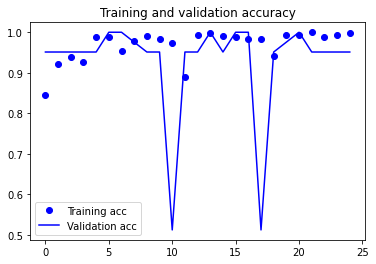

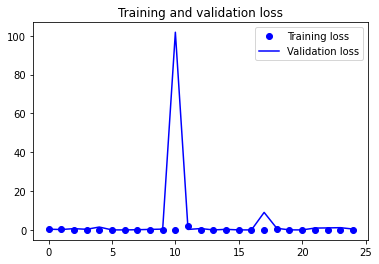

In [49]:
import matplotlib.pyplot as plt

acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

From the figures, sharp spikes has been observed. During the training at around the 11th epoch, the validation loss abruptly increased. However, as the training goes on to the last epoch, the loss function reduces to a small value.

### Model testing

80% of the data has been set for training and 10% has been set for validation. To check our model, the remaining 10% (testData) will be used for prediction. 


In [41]:
from keras.models import load_model
model = load_model('blur_detection_model')
predictions = model.predict(testData, steps=len(testData), verbose=0)
predictions = np.round(predictions)
predictions

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [43]:
testData.class_indices

{'blurry': 0, 'notblurry': 1}

Here, i am using next function to extract a batch of images and their corresponding labels from the test set. Recall that the 44 samples are loaded in 1 batch for the test data. The output here is a 2D array: class and the image label.

In [37]:
test_imgs, test_labels = next(testData)

print(test_labels)

[[1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]


Accuracy: 97.73%
Precision: 100.00%
Recall: 95.45%
F1-score: 97.67


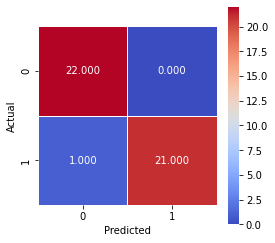

In [42]:
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score,roc_curve, auc, accuracy_score
import seaborn as sns
from sklearn.model_selection import cross_val_score

# confusion matrix 
cm = confusion_matrix(test_labels.argmax(axis=1), predictions.argmax(axis=1))

# Representing the confusion matrix in a heat map

plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square=True, cmap='coolwarm');
plt.ylabel('Actual')
plt.xlabel('Predicted');

#check accuracy
acc = accuracy_score(test_labels, predictions)*100
tn, fp, fn, tp = cm.ravel()
accuracy = (tp+tn)/(tp+fp+tn+fn)*100
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {0:0.2f}%'.format(accuracy))
print('Precision: {0:0.2f}%'.format(precision))
print('Recall: {0:0.2f}%'.format(recall))
print('F1-score: {0:0.2f}'.format(2*precision*recall/(precision+recall)))

In [51]:
from sklearn.metrics import roc_auc_score
score = roc_auc_score(test_labels, predictions)*100
print(f"ROC AUC: {score:.4f}")

ROC AUC: 97.7273
